## Bootstrap study
### How to use correctly the bootstrap technique

You can assess any statistical measure of population, here I'm gonna use a classification score from a trained model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
n_samples = 20000
n_features = 4

X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features,
                           class_sep=0.6,
                           )



dict_freq_labels = {}
print (f'Unique classes in y: {np.unique(y)}')
for label in np.unique(y):
    print (f'count of label {label}: {(y==label).sum()}')
    dict_freq_labels[label] = (y==label).sum()/y.size
print (dict_freq_labels)


rng = np.random.RandomState()

Unique classes in y: [0 1]
count of label 0: 10003
count of label 1: 9997
{0: 0.50015, 1: 0.49985}


### Looking for a 'true' score (using auc here)

Testing for several k-fold cross validation and a train/test set.

If all results gives the same score (regarding some decimal places) then its probably a good true result for the experiment.

In [3]:
clf = LogisticRegression()

print ('Results for k-fold cross-validation')

for cv in range(2,21):
    v = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    print (f'cv: {cv}, mean auc: {v.mean():.3f}, stddev: {v.std():.3f}')

# I'm setting the true score value as the last k, but you must confirm from the results
auc_true = v.mean()

print ()
print ('Result for training/test set, frac test_set=0.3')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                test_size=0.3,
                                shuffle=True, 
                                random_state=rng,
                                )

clf.fit(X_train, y_train)
print (f'{roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]):.3f}')
auc_score_train_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

Results for k-fold cross-validation
cv: 2, mean auc: 0.862, stddev: 0.001
cv: 3, mean auc: 0.862, stddev: 0.001
cv: 4, mean auc: 0.862, stddev: 0.003
cv: 5, mean auc: 0.862, stddev: 0.005
cv: 6, mean auc: 0.862, stddev: 0.004
cv: 7, mean auc: 0.862, stddev: 0.007
cv: 8, mean auc: 0.862, stddev: 0.006
cv: 9, mean auc: 0.862, stddev: 0.007
cv: 10, mean auc: 0.862, stddev: 0.006
cv: 11, mean auc: 0.862, stddev: 0.009
cv: 12, mean auc: 0.862, stddev: 0.008
cv: 13, mean auc: 0.862, stddev: 0.010
cv: 14, mean auc: 0.862, stddev: 0.008
cv: 15, mean auc: 0.862, stddev: 0.010
cv: 16, mean auc: 0.862, stddev: 0.009
cv: 17, mean auc: 0.862, stddev: 0.008
cv: 18, mean auc: 0.862, stddev: 0.009
cv: 19, mean auc: 0.862, stddev: 0.010
cv: 20, mean auc: 0.862, stddev: 0.011

Result for training/test set, frac test_set=0.3
0.861


### Now we are gonna simulate a small dataset. Sampling from the original distribution.

In [4]:
# will use test set as new sampled dataset
_, X1, _, y1 = train_test_split(X, y,
                                test_size=0.005,
                                shuffle=True, 
                                random_state=rng,
                                )

print (f'New dataset shape: {X1.shape}')

list_count = list()
for label in np.unique(y1):
    print (f'count of label {label}: {(y1==label).sum()}')
    list_count.append((y1==label).sum())

min_label_count = np.array(list_count).min()

New dataset shape: (100, 4)
count of label 0: 51
count of label 1: 49


### Here is what I see people doing

[Example]

[1] Given a dataset with 100 samples. 

[2] Sample 100 samples with replacement, train model / calculate the score.

[3] Repeat step 2, N times.

[4] Final step, calculate the mean score and the std of the mean, given by:

$$
\sigma_{mean} = \frac{\sigma}{\sqrt{N}}.
$$

The problem is to think that increasing $N$ will give a better mean score, with a narrower uncertainty.

Let's look at the generated figure. The mean and uncertainty of the mean calculated this way deviates clearly from the true score.

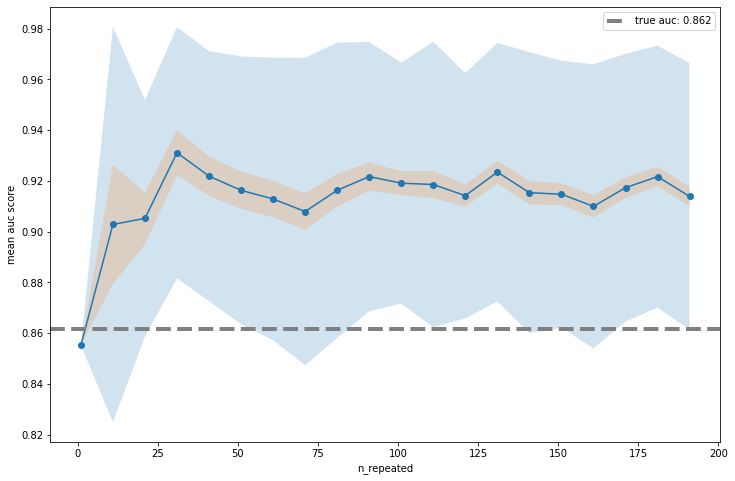

In [5]:
# will use test set as new sampled dataset
n_repeated_max = 200


list_of_mean_scores = list()
list_of_std_scores = list()
list_of_rep = list()


for n_repeated in range(1, n_repeated_max, 10):

    v = list()

    for i in range(n_repeated):


        idxs_bootstrap = np.random.choice(range(X1.shape[0]), size=X1.shape[0], replace=True)
        X_boots = X1[idxs_bootstrap, :]
        y_boots = y1[idxs_bootstrap]

        X_train, X_test, y_train, y_test = train_test_split(X_boots, y_boots,
                                                test_size=0.3,
                                                shuffle=True, 
                                                random_state=rng,
                                                )

        clf.fit(X_train, y_train)
        v.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

    list_of_mean_scores.append(np.array(v).mean())
    list_of_std_scores.append(np.array(v).std())
    list_of_rep.append(n_repeated)

#
plt.figure(figsize=(12, 8))
plt.plot(list_of_rep, list_of_mean_scores, '-o')
plt.fill_between(list_of_rep, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores), 
                 alpha=0.2)
plt.fill_between(list_of_rep, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores)/np.sqrt(list_of_rep), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores)/np.sqrt(list_of_rep), 
                 alpha=0.2)
plt.axhline(y=auc_true, color='gray', linestyle='--', lw=4, label=f'true auc: {auc_true:.3f}')
plt.xlabel('n_repeated')
plt.ylabel('mean auc score')
plt.legend()

### But how bootstrap works then?

TODO here.

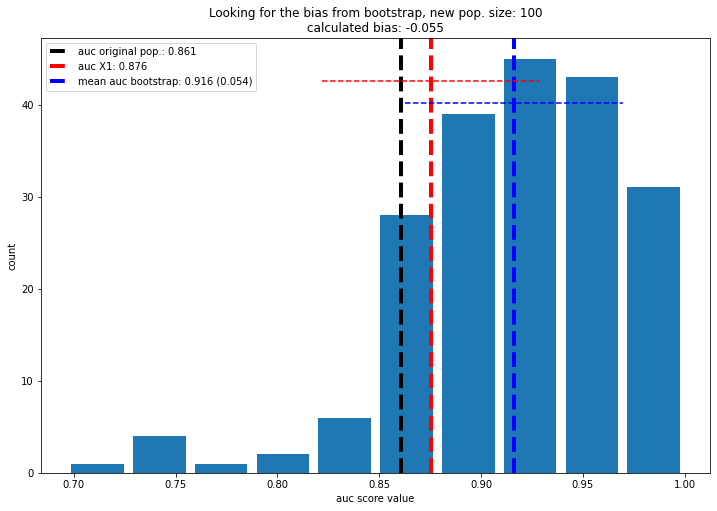

In [6]:
list_of_scores = list()

X_train, X_test, y_train, y_test = train_test_split(X1, y1,
                                        test_size=0.3,
                                        shuffle=True, 
                                        random_state=rng,
                                        )

clf.fit(X_train, y_train)
auc_X1 = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

for i in range(200):

    idxs_bootstrap = np.random.choice(range(X1.shape[0]), size=X1.shape[0], replace=True)
    #print (idxs_bootstrap)
    X_boots = X1[idxs_bootstrap, :]
    y_boots = y1[idxs_bootstrap]

    X_train, X_test, y_train, y_test = train_test_split(X_boots, y_boots,
                                            test_size=0.3,
                                            shuffle=True, 
                                            random_state=rng,
                                            )


    clf.fit(X_train, y_train)
    list_of_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.figure(figsize=(12, 8))
plt.hist(list_of_scores, rwidth=0.85)
plt.axvline(x=auc_score_train_test, lw=4, linestyle='--', color='black', label=f'auc original pop.: {auc_score_train_test:.3f}')
plt.axvline(x=auc_X1, lw=4, linestyle='--', color='red', label=f'auc X1: {auc_X1:.3f}')
plt.axvline(x=np.mean(list_of_scores), lw=4, linestyle='--', color='blue', label=f'mean auc bootstrap: {np.mean(list_of_scores):.3f} ({np.std(list_of_scores):.3f})')
plt.legend()
plt.title(f'Looking for the bias from bootstrap, new pop. size: {X1.shape[0]}\ncalculated bias: {auc_score_train_test-np.mean(list_of_scores):.3f}')
plt.xlabel('auc score value')
plt.ylabel('count')

axes = plt.gca()
y_min, y_max = axes.get_ylim()

plt.plot([np.mean(list_of_scores) - np.std(list_of_scores), np.mean(list_of_scores) + np.std(list_of_scores)], [y_max*0.85, y_max*0.85],
         linestyle='--',
         color='blue',)

plt.plot([auc_X1 - np.std(list_of_scores),auc_X1 + np.std(list_of_scores)], [y_max*0.9, y_max*0.9],
         linestyle='--',
         color='red',)

### Bootstrap evolution

### Using k-fold cross-validation

k-fold cross-validation varying k to see bias-variance phenomenon.

computing cv=10...
computing cv=20...
computing cv=30...
computing cv=40...


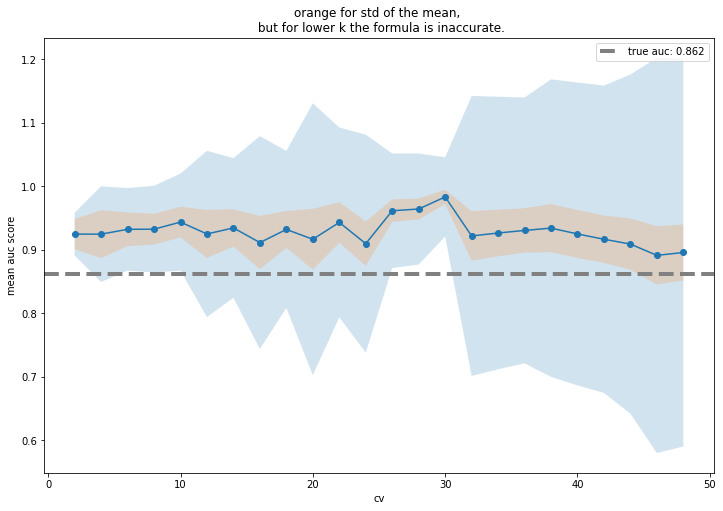

In [7]:
clf = LogisticRegression()

#n1 = X1.shape[0]//2

list_of_mean_scores = list()
list_of_std_scores = list()
list_of_cv = list()


for cv in range(2, min_label_count, 2):
    if cv % 10 == 0:
        print (f'computing cv={cv}...')
    v = cross_val_score(clf, X1, y1, cv=cv, scoring='roc_auc')
    #print (f'cv: {cv}, mean auc: {v.mean():.3f}, stddev: {v.std():.3f}')
    list_of_mean_scores.append(v.mean())
    list_of_std_scores.append(v.std())
    list_of_cv.append(cv)

plt.figure(figsize=(12, 8))
plt.plot(list_of_cv, list_of_mean_scores, '-o')
plt.fill_between(list_of_cv, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores), 
                 alpha=0.2)
plt.fill_between(list_of_cv, 
                 np.array(list_of_mean_scores) - np.array(list_of_std_scores)/np.sqrt(list_of_cv), 
                 np.array(list_of_mean_scores) + np.array(list_of_std_scores)/np.sqrt(list_of_cv), 
                 alpha=0.2)
plt.axhline(y=auc_true, color='gray', linestyle='--', lw=4, label=f'true auc: {auc_true:.3f}')
plt.xlabel('cv')
plt.ylabel('mean auc score')
plt.title('orange for std of the mean, \n but for lower k the formula is inaccurate.')
plt.legend()

### Appendice stuff, dont know if I gonna use it.

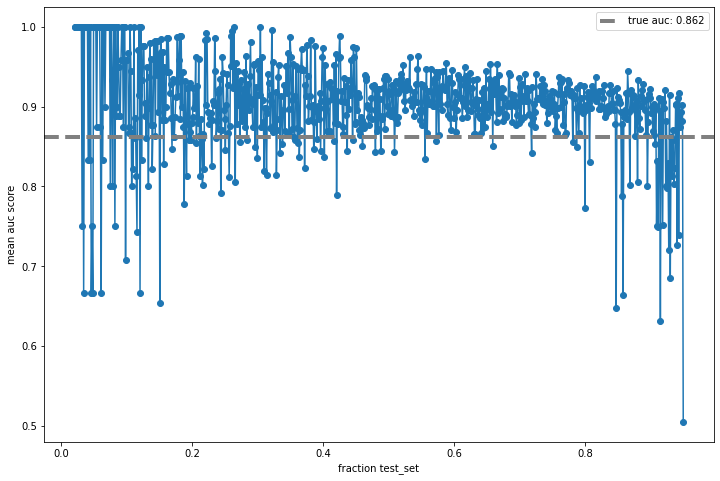

In [8]:
vector_fraction_test_set = np.linspace(0.02, 0.95, 800)

list_of_scores = list()
list_of_frac = list()

for fraction_test_set in vector_fraction_test_set:
    X_train, X_test, y_train, y_test = train_test_split(X1, y1,
                                            test_size=fraction_test_set,
                                            shuffle=True, 
                                            random_state=rng,
                                            )


    try: # as vezes nao aparece todas as classes no grupo de training ou teste, por isso o try
        clf.fit(X_train, y_train)
        list_of_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    except:
        continue
    list_of_frac.append(fraction_test_set)


#
plt.figure(figsize=(12, 8))
plt.plot(list_of_frac, list_of_scores, '-o')
plt.axhline(y=auc_true, color='gray', linestyle='--', lw=4, label=f'true auc: {auc_true:.3f}')
plt.xlabel('fraction test_set')
plt.ylabel('mean auc score')
plt.legend()